In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import string
import random
from collections import defaultdict
import cv2
import statistics

np.random.seed(7)

# Dataset

In [2]:
captchas=os.listdir('dataset')
names=[name.split('.')[0] for name in captchas]
n=len(captchas)
img_shape=cv2.imread("dataset/"+captchas[0]).shape
symbols=string.ascii_lowercase+string.ascii_uppercase+string.digits
num_symbols=len(symbols)

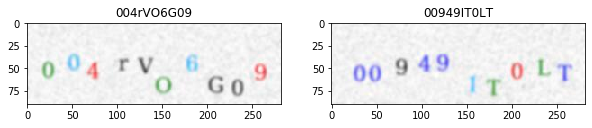

In [3]:
#Primeri nekih uzoraka
first=cv2.imread('dataset/'+captchas[0])
second=cv2.imread('dataset/'+captchas[1])
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title(names[0])
plt.imshow(first)
plt.subplot(1,2,2)
plt.title(names[1])
plt.imshow(second)

# Kako preprocesirati slike

Do ovih rezultata smo dosli eksperimentalno.
slede neki pokusaji koji ilustruju kako smo dosli do njih.

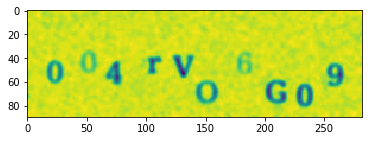

In [4]:
proc1_first=cv2.cvtColor(first,cv2.COLOR_BGR2RGB)
proc2_first=cv2.cvtColor(proc1_first,cv2.COLOR_RGB2GRAY)
plt.imshow(proc2_first)

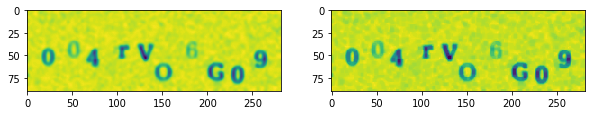

In [5]:
blur = cv2.GaussianBlur(proc2_first,(3,3),5)
kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(proc2_first, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(blur)
plt.subplot(1,2,2)
plt.imshow(closing)

pokusaj otklanjanja suma

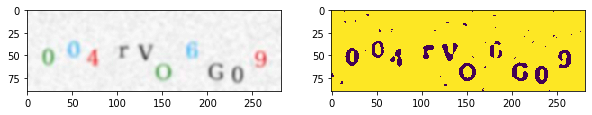

In [6]:
img=first
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,3)
blur = cv2.GaussianBlur(dst,(5,5),5)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,3)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(dst)
plt.subplot(1,2,2)
plt.imshow(thresh)

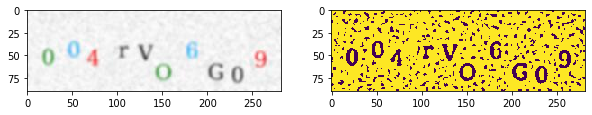

In [7]:
img=first
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,3)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(thresh)

Pozadina nam pravi probleme pri izdvajanju simbola

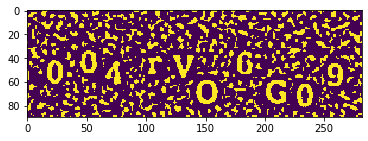

In [8]:
blur = cv2.GaussianBlur(gray, (3,3),6) 
threshold_img = cv2.adaptiveThreshold(proc2_first,255,1,1,11,2)
plt.imshow(threshold_img)

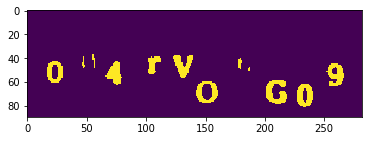

In [9]:
_, binary = cv2.threshold(gray, 205, 252, cv2.THRESH_BINARY_INV)
plt.imshow(binary)

# Preprocesiranje koje cemo izvesti

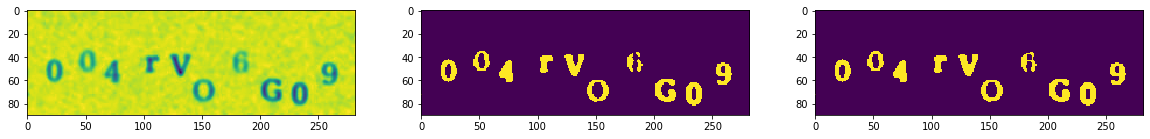

In [10]:
#Prikaz transformacija koje cemo izvrsiti nad slikama
proc1_first=cv2.cvtColor(first,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(proc1_first, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(20,50))
plt.subplot(1,3,1)
plt.imshow(gray)

thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.subplot(1,3,2)
plt.imshow(thresh)

kernel = np.ones((3,3),np.uint8)
thresh= cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.subplot(1,3,3)
plt.imshow(thresh)

Nakon toga zelimo da izdvojimo konture

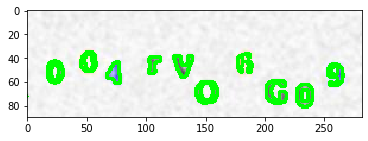

In [11]:
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
image = cv2.drawContours(proc1_first, cnts, -1, (0, 255, 0), 2)
plt.imshow(image)

Obrada slike i izdvajanje delova. Moguce je i prikazati izdvojene delove i sacuvati ih.
Prvo radimo gore opisane transformacije slike i izdvajanje kontura. Zatim sve izdvojene konture cuvamo ako su ispravne.
Automatizujemo proveru ispravnosti. Posto je pozadina sumovita potrebne su nam dodatne provere kako bismo izbegli cuvanje pozadinskog suma kao konture. Takodje moramo paziti da su simboli u celosti izdvojeni.

In [12]:
#j je indeks slike u datasetu, prikaz,save i samo su objasnjeni u glavnom delu
def obrada(j,prikaz=False,save=False,samo=False):
    first=cv2.imread('dataset/'+ captchas[j])
    hs,ws=first.shape[:2]
    P=hs*ws #povrsina slike
    
    proc1_first=cv2.cvtColor(first,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(proc1_first, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel = np.ones((3,3),np.uint8)
    thresh= cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
    #gore opisano preprocesiranje i izdvajanje kontura

    eps=1
    number = 0
    xp=0
    wp=0
    pp=0
    xmax=0
    xpp=[]
    xpk=[]
    ypp=[]
    delova=0
    if prikaz:
        plt.figure(figsize=(20,50))
    i=1
    
    imgs=dict([]) #za izdvajanje slika
    imgsamo=defaultdict(list) #za izdvajanje kada samo zelimo da preprocesiramo
    
    for c in cnts:
        area = cv2.contourArea(c) #povrsina izdvojenog dela
        x,y,w,h = cv2.boundingRect(c)
        #slede provere do kojih sam nazalost eksperimentalno dosla, detaljnije ce biti usmeno objasnjeno
        #ideja je da se izbegnu mali sumovi, da se proveri da li je ce simbol uzet i da se resi problem bliskih simbola
        
        if (x+w)>xmax:
            xmax=x+w
        if x>=xp and ((x+w)<=(xp+wp) or xmax>(x+w)):
            xp=x
            wp=w
            continue
        elif area<P/30 and area>P/500:
            if(i>10 and not samo):
                return -1
            if pp>P/700:
                number += 1
                n=len(xpp)
                
                ROI =thresh[max(min(ypp)-eps,0):min(max(ypp)+eps,hs),max(min(xpp)-eps,0):min(max(xpk),ws)]
                imgs[names[j][i-1]+str(i)]=ROI
                if samo:
                    imgsamo[0].append(ROI)
                if prikaz:
                    plt.subplot(1,10,i)
                    plt.title(names[j][i-1])
                    plt.imshow(ROI,cmap='gray')
                i=i+1
            if(i>10 and not samo):
                return -1
            pp=0
            xpp=[]
            xpk=[]
            ypp=[]
            ROI=thresh[max([y-eps,0]):min([y+h+eps,hs]),max([x-eps,0]):min([x+w,ws])]
            ROI =thresh[y:y+h, x:x+w]
            
            imgs[names[j][i-1]+str(i)]=ROI
            if samo:
                imgsamo[0].append(ROI)
            
            if prikaz:
                plt.subplot(1,10,i)
                plt.title(names[j][i-1])
                plt.imshow(ROI,cmap='gray')
                
            i=i+1
            number += 1
            xp=x
            wp=w
        else:
            if(i>10 and not samo):
                return -1
            if pp>P/700:
                number += 1
                n=len(xpp)
                
                ROI =thresh[max(min(ypp)-eps,0):min(max(ypp)+eps,hs),max(min(xpp)-eps,0):min(max(xpk),ws)]
                imgs[names[j][i-1]+str(i)]=ROI
                if samo:
                    imgsamo[0].append(ROI)
                    
                if prikaz:
                    plt.subplot(1,10,i)
                    plt.title(names[j][i-1])
                    plt.imshow(ROI,cmap='gray')
                i=i+1
                pp=0
                xpp=[]
                xpk=[]
                ypp=[]
            if(area<5):
                continue
            pp=pp+area
            delova=delova+1
            xpp=xpp+[x]
            xpk=xpk+[x+w]
            ypp=ypp+[y]+[y+h]
            
    
    if pp>P/700:
        if(i>10 and not samo):
            return -1
        number += 1
        n=len(xpp)
        ROI =thresh[max(min(ypp)-eps,0):min(max(ypp)+eps,hs),max(min(xpp)-eps,0):min(max(xpk),ws)]
        imgs[names[j][i-1]+str(i)]=ROI
        if samo:
            imgsamo.append(ROI)
            
        if prikaz:
            plt.subplot(1,10,i)
            plt.title(names[j][i-1])
            plt.imshow(ROI,cmap='gray')
        i=i+1
        pp=0
        xpp=[]
        xpk=[]
        ypp=[]
    
    if samo:
        return imgsamo

    if(number==10 and not prikaz):
        for (kljuc, vrednost) in imgs.items():
            prop=len(vrednost[vrednost==255])/(len(vrednost)*len(vrednost[0]))
            if prop>0.85 or prop<0.1:
                continue
            
            #ukoliko cuvate slike svi izdvojeni ismboli ce biti sacuvani, naziv ce nam reci iz koje slike je izdvojen simbol
            #mozete uraditi kako biste proverili da li su izdvojeni delovi ispravni (ali dataset je veliki)
            #izdvojeni delovi bice demonstrirani pri odbrani
            if save:
                cv2.imwrite('v2/{}.png'.format(kljuc+names[j]), vrednost)
            
            slike[0].append(vrednost)
            ypom=np.zeros(len(symbols))
            ypom[symbols.find(kljuc[0])]=1
            vrednosti[0].append(ypom)

primer obrade slika


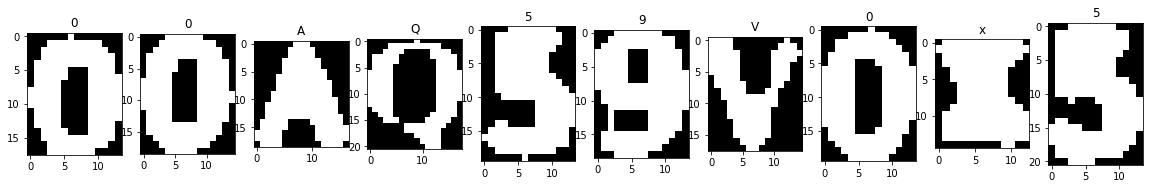

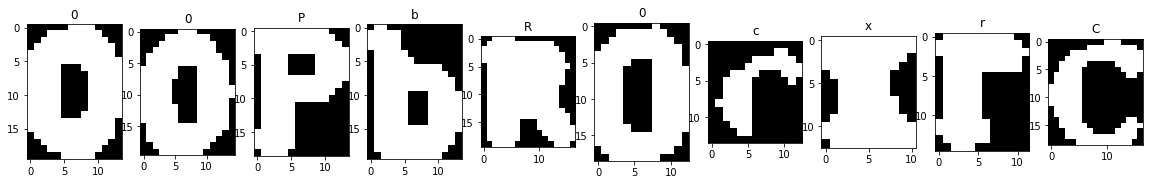

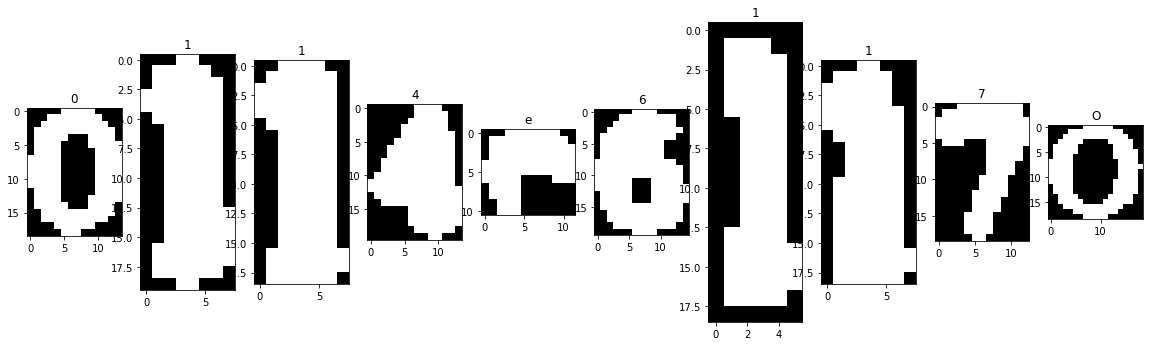

In [13]:
print("primer obrade slika")
obrada(3,prikaz=True)
obrada(7,prikaz=True)
obrada(10,prikaz=True)
#prikaz=True omogucava da prikazemo isparsirane delove bez cuvanja vrednosti i bez filtriranja
#napomena-prikaz sluzi samo za demonstraciju, td pri pokretanju sa prikaz=True moze biti gresaka
#pri obradi vrsimo filtriranja i cuvanja izdvojenih delova u strukturama

In [14]:
#dobijeni delovi nisu istih dimenzija,svescemo sve delove na iste dimenzije
def promena_dimenzija(img_list,trening=True,interpolation=cv2.INTER_CUBIC):
    im_list_resize=[cv2.resize(img,(int(v),int(h)),interpolation=interpolation) for img in img_list]
    
    return im_list_resize

obradicemo samo prvu sliku kako bismo demonstrirali bez da cekamo da se sve slike obrade

In [15]:
slike = defaultdict(list)
vrednosti=defaultdict(list)

obrada(0)

In [16]:
img_list=slike[0]
h=statistics.mean([img.shape[0] for img in img_list])
v=statistics.mean([img.shape[1] for img in img_list])
print("Prosecne dimenzije izdvojenih slika: ",h,v)

Xall=promena_dimenzija(img_list)

Prosecne dimenzije izdvojenih slika:  18.5 14.6


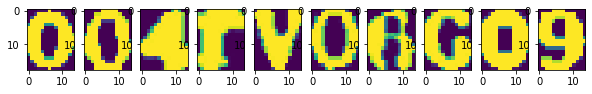

In [17]:
plt.figure(figsize=(10,5))
n=len(Xall)
for i in range(1,n+1):
    plt.subplot(1,n,i)
    plt.imshow(Xall[i-1])

# Mogucnost rekonstrukcije slike

In [18]:
#spajanje slika horizontalnim nadovezivanjem
def hconcat_resize(img_list,interpolation=cv2.INTER_CUBIC):
    h_min=min(img.shape[0] for img in img_list)
    im_list_resize=[cv2.resize(img,(int(img.shape[1]*h_min/img.shape[0]),h_min),interpolation=interpolation) for img in img_list]
    
    return cv2.hconcat(im_list_resize)

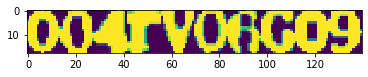

In [19]:
slika=hconcat_resize(Xall)
plt.imshow(slika)